In [1]:
import pandas as pd
import json, os, sys, glob
import numpy as np
import h5py
import tensorflow as tf
from IPython.display import Image,display
import matplotlib.pyplot as plt
import tarfile
from six.moves.urllib.request import urlretrieve
import seaborn as sns
%matplotlib inline

# 1. Download and decompress dataset

In [2]:
def may_create_folder(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    print("Folder %s present now" % folder)

#may_create_folder("./test")

In [3]:
download_site = "http://ufldl.stanford.edu/housenumbers/"
data_root = "./data"
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent

def may_download(tar_file_name, expected_size, force = False):
    dest_filename = os.path.join(data_root, tar_file_name)
    if force or not os.path.exists(dest_filename):
        print("Attempt to download file " + tar_file_name)
        file_name, _ = urlretrieve( download_site + tar_file_name, dest_filename, reporthook=download_progress_hook)
        print("Download complete!")
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_size:
        print("Downloaded and verified file : " + dest_filename)
    else:
        raise Exception("Failed to verify file : " + dest_filename)
    return dest_filename
    
may_create_folder(data_root)
test_filename = may_download("test.tar.gz", 276555967)
train_filename = may_download("train.tar.gz", 404141560)

Folder ./data present now
Downloaded and verified file : ./data/test.tar.gz
Downloaded and verified file : ./data/train.tar.gz


In [4]:
import os, tarfile

def maybe_extract(filename, force = False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    if os.path.isdir(root) and not force:
        print("{0} already present --- Skipping extraction of {1}".format(root, filename))
    else:
        print("Extract data for {0}, this may take a while, please wait ..".format(filename))
        tar = tarfile.open(filename)
        tar.extractall()
        tar.close()
    return  root

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
        

./data/train already present --- Skipping extraction of ./data/train.tar.gz
./data/test already present --- Skipping extraction of ./data/test.tar.gz


# 2. Transform .mat file to Json file
Use the python script taken from http://www.a2ialab.com/lib/exe/fetch.php?media=public:scripts:svhn_dataextract_tojson.py.txt

In [5]:
digit_struct_files = glob.glob('./data/*/*.mat')
print(digit_struct_files)

['./data/train/digitStruct.mat', './data/test/digitStruct.mat']


In [6]:
jsons_root = './jsons'

def transform_mat_to_json():
    transform_json_script = "python svhn_dataextract_tojson.py -f ./data/{0}/digitStruct.mat -o ./jsons/{0}/digitStruct"
    for file_type in ['train', 'test']:
        output_folder = os.path.join(jsons_root, file_type)
        if not os.path.exists(output_folder):
            os.mkdir(output_folder)
        if os.path.exists(os.path.join(output_folder, 'digitStruct.json')):
            continue
        print("Begin transform %s files" % file_type)
        os.system(transform_json_script.format(file_type))
        print("End transform %s files" % file_type)
    print("Complete !")
    
may_create_folder(jsons_root)
transform_mat_to_json()    

Folder ./jsons present now
Complete !


# 3. Load json files and extract information from json files

In [9]:
def get_json_information(json_file):
    '''
    
    :param json_file: path of json files
    :return: 
      result format : [{'filename':'*.png', 'bbox_x1': value, 'bbox_y1':value, 'bbox_width':value, 'bbox_height': value,
      'boxes':np.array([{'left':value, 'top':value, 'width':value, 'height':value}, ..]), labels:np.array([val1, val2,..])}, ...]
      'filename' : name of image file
      'bbox_x1' : left coordinate of bounding box
      'bbox_y1' : top coordinate of bounding box
      'bbox_width : width of bounding box
      'bbox_height' : height of bounding box
      'boxes' : all box in the image
      'boxes'.'left': left coordinate of one box
      'boxes'.'top' : top coordinate of one box
      'boxes'.'widht' : width of one box
      'boxes'.'height' : height of one box
    '''
    if not os.path.exists(json_file):
        raise Exception("{0} is not exist".format(json_file))

    with open(json_file, 'r') as file:
        json_info = json.load(file)
    results = []
    for info in json_info:
        digit_info = {}
        digit_info['filename'] = info['filename']

        boxes = info['boxes']
        x1 = int(np.min([box['left'] for box in boxes]))
        y1 = int(np.min([box['top'] for box in boxes]))
        x2 = int(np.max([box['left'] + box['width'] for box in boxes]))
        y2 = int(np.max([box['top'] + box['height'] for box in boxes]))

        digit_info['bbox_x1'] = x1
        digit_info['bbox_y1'] = y1
        digit_info['boxes'] = np.array([{ name : int(box[name]) for name in ['left', 'top', 'width', 'height']}  for box in boxes])
        digit_info['bbox_width'] = x2 - x1
        digit_info['bbox_height'] = y2 - y1
        digit_info['labels'] = np.array([int(box['label']) for box in boxes])
        digit_info['digit_count'] = len(digit_info['labels'])
        results.append(digit_info)
    return results

train_json_file_path = os.path.join(jsons_root, 'train/digitStruct.json')
test_json_file_path = os.path.join(jsons_root, 'test/digitStruct.json')
train_json_info = get_json_information(train_json_file_path)
test_json_info = get_json_information(test_json_file_path)
print("Train json info : \n", train_json_info[0:5])
print("=" * 50)
print("Test json info : \n", test_json_info[0:5])

Train json info : 
 [{'filename': '1.png', 'bbox_x1': 246, 'bbox_y1': 77, 'boxes': array([{'left': 246, 'top': 77, 'width': 81, 'height': 219},
       {'left': 323, 'top': 81, 'width': 96, 'height': 219}], dtype=object), 'bbox_width': 173, 'bbox_height': 223, 'labels': array([1, 9]), 'digit_count': 2}, {'filename': '2.png', 'bbox_x1': 77, 'bbox_y1': 25, 'boxes': array([{'left': 77, 'top': 29, 'width': 23, 'height': 32},
       {'left': 98, 'top': 25, 'width': 26, 'height': 32}], dtype=object), 'bbox_width': 47, 'bbox_height': 36, 'labels': array([2, 3]), 'digit_count': 2}, {'filename': '3.png', 'bbox_x1': 17, 'bbox_y1': 5, 'boxes': array([{'left': 17, 'top': 5, 'width': 8, 'height': 15},
       {'left': 25, 'top': 5, 'width': 9, 'height': 15}], dtype=object), 'bbox_width': 17, 'bbox_height': 15, 'labels': array([2, 5]), 'digit_count': 2}, {'filename': '4.png', 'bbox_x1': 57, 'bbox_y1': 13, 'boxes': array([{'left': 57, 'top': 13, 'width': 15, 'height': 34},
       {'left': 72, 'top': 13

# 4. Analyze data to filter low-quality data
## 4.1 Show the distribution of bounding box width and length

In [10]:
train_pd = pd.DataFrame(train_json_info)
test_pd = pd.DataFrame(test_json_info)
print("Shape of train_pd : ", train_pd.shape)
print(train_pd.head())
print("=" * 40)
print("Shape of test_pd : ", test_pd.shape)
print(test_pd.head())

Shape of train_pd :  (33402, 8)
   bbox_height  bbox_width  bbox_x1  bbox_y1  \
0          223         173      246       77   
1           36          47       77       25   
2           15          17       17        5   
3           34          28       57       13   
4           49          37       52        7   

                                               boxes  digit_count filename  \
0  [{'left': 246, 'top': 77, 'width': 81, 'height...            2    1.png   
1  [{'left': 77, 'top': 29, 'width': 23, 'height'...            2    2.png   
2  [{'left': 17, 'top': 5, 'width': 8, 'height': ...            2    3.png   
3  [{'left': 57, 'top': 13, 'width': 15, 'height'...            2    4.png   
4  [{'left': 52, 'top': 7, 'width': 21, 'height':...            2    5.png   

   labels  
0  [1, 9]  
1  [2, 3]  
2  [2, 5]  
3  [9, 3]  
4  [3, 1]  
Shape of test_pd :  (13068, 8)
   bbox_height  bbox_width  bbox_x1  bbox_y1  \
0           30          19       43        7   
1          

count    33402.000000
mean        37.085923
std         21.565733
min          9.000000
25%         23.000000
50%         31.000000
75%         45.000000
max        423.000000
Name: bbox_height, dtype: float64
count    33402.000000
mean        36.256601
std         24.302514
min          3.000000
25%         20.000000
50%         30.000000
75%         46.000000
max        616.000000
Name: bbox_width, dtype: float64


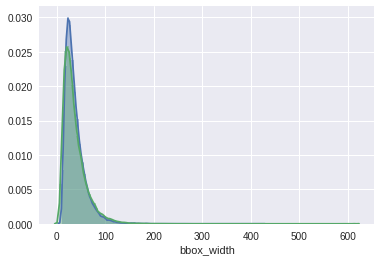

In [36]:
bin_size = 5
bins = np.arange(0, np.max(train_pd.bbox_height) + 5, bin_size)
print(train_pd.bbox_height.describe())
print(train_pd.bbox_width.describe())
sns.distplot(train_pd.bbox_height, bins=bins)
sns.distplot(train_pd.bbox_width, bins=bins)

The distributions between train and test are familiar with both peaking around an image height of 25 pixes. We will drop poor quality images with smaller heights.

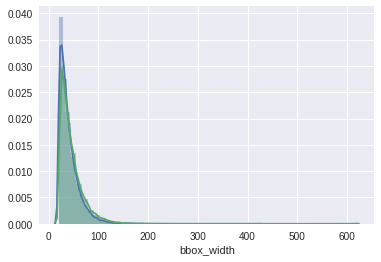

In [37]:
valid_train_pd = train_pd.loc[train_pd.bbox_height >= 20, :]
sns.distplot(valid_train_pd.bbox_height)
valid_train_pd = valid_train_pd.loc[train_pd.bbox_width >= 20, :]
sns.distplot(valid_train_pd.bbox_width)

In [41]:
print("Train digit count :\n ", valid_train_pd.digit_count.value_counts())
print("=" * 40)
print("Test digit count : \n", test_pd.digit_count.value_counts())

Train digit count :
  2    13529
3     7570
1     1741
4      898
5        7
Name: digit_count, dtype: int64
Test digit count : 
 2    8356
1    2483
3    2081
4     146
5       2
Name: digit_count, dtype: int64


## Load and analyze data first
1. Load mat data and transform to json